# 02 Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from scipy.stats import median_abs_deviation

In [2]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Optional: widen the column width and overall display width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

In [3]:
df: pd.DataFrame = pd.read_csv('../data/raw/Data Smart Meter.csv')
df.head()

/var/folders/0z/26cwjfqx4fj73hndqg4mkgl80000gn/T/ipykernel_2802/3637550019.py:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = pd.read_csv('../data/raw/Data Smart Meter.csv')


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [4]:
# Clean: coerce non-numeric `time` values to NaN
df['time'] = pd.to_numeric(df['time'], errors='coerce')

# Drop rows with invalid or missing timestamps
df = df.dropna(subset=['time'])

# Convert valid timestamps to datetime
df['time'] = pd.to_datetime(df['time'], unit='s')

In [5]:
df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,2016-01-01 05:00:01,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,2016-01-01 05:00:02,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,2016-01-01 05:00:03,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,2016-01-01 05:00:04,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [6]:
def plot_total_energy_use_over_time(dataframe: pd.DataFrame) -> None:
    """
    Plots the total household energy consumption over time.
    """
    timestamp_indexed_df: pd.DataFrame = dataframe.copy()
    timestamp_indexed_df['time'] = pd.to_datetime(timestamp_indexed_df['time'])
    timestamp_indexed_df.set_index('time', inplace=True)

    energy_usage_column: str = 'use [kW]'

    plt.figure(figsize=(12, 5))
    plt.plot(timestamp_indexed_df.index, timestamp_indexed_df[energy_usage_column], linewidth=0.8)
    plt.title('Total Energy Usage Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Use [kW]')
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()

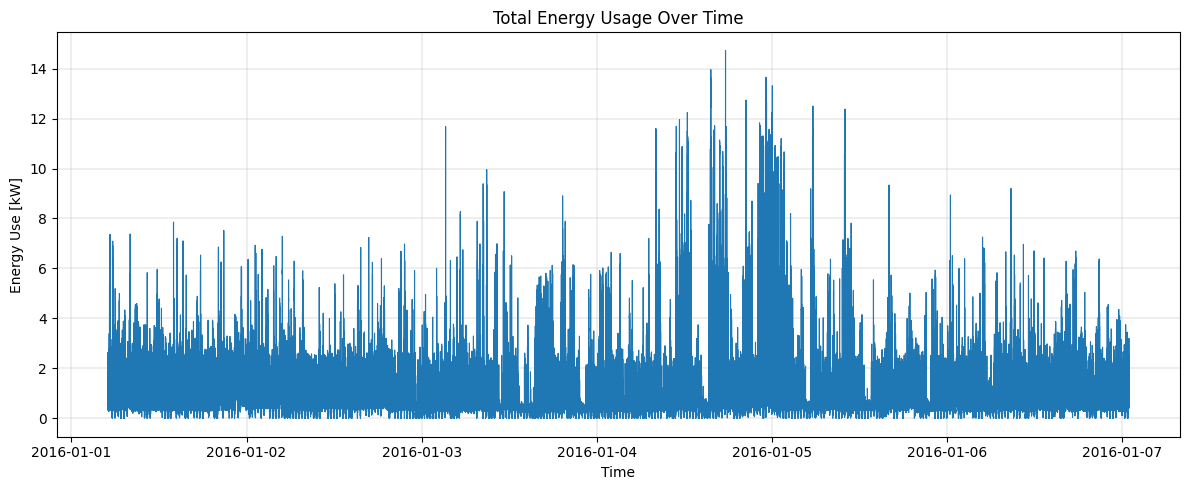

In [7]:
plot_total_energy_use_over_time(df)

The plot shows clear daily and intraday variation in total energy use. Peaks likely correspond to high-usage periods (e.g. morning/evening activity), while the sharp drops suggest idle or sleep times. The sustained spike around Jan 4–5 hints at abnormal or intensive appliance usage. 

In [8]:
def plot_energy_vs_temperature(df: pd.DataFrame) -> None:
    """
    Scatter plot of energy use vs. temperature to check correlation.
    """
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df,
        x='temperature',
        y='use [kW]',
        alpha=0.3,
        edgecolor=None
    )
    plt.title('Energy Use vs. Temperature')
    plt.xlabel('Temperature [°F]')
    plt.ylabel('Energy Use [kW]')
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()

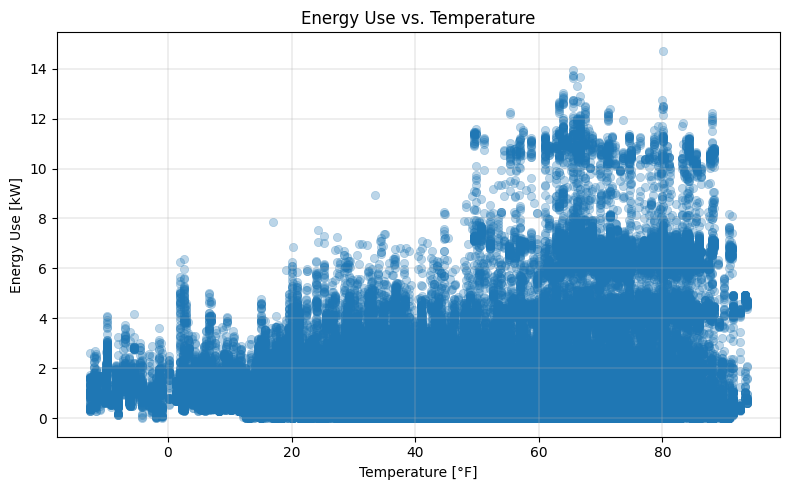

In [9]:
plot_energy_vs_temperature(df)

The scatter plot suggests a non-linear relationship between temperature and energy use. Energy consumption increases with temperature up to around 65–75°F, then declines. This pattern likely reflects heating during low temps, cooling during higher temps—with a sweet spot of minimal energy use in moderate temperatures

NOTE: some feature engineering might be useful

In [10]:
def plot_energy_vs_weather(df: pd.DataFrame) -> None:
    """
    Box plot of energy use across different weather summaries.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df,
        x='summary',
        y='use [kW]',
        showfliers=False
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Energy Use vs. Weather Conditions')
    plt.xlabel('Weather Summary')
    plt.ylabel('Energy Use [kW]')
    plt.tight_layout()
    plt.grid(axis='y', linewidth=0.3)
    plt.show()

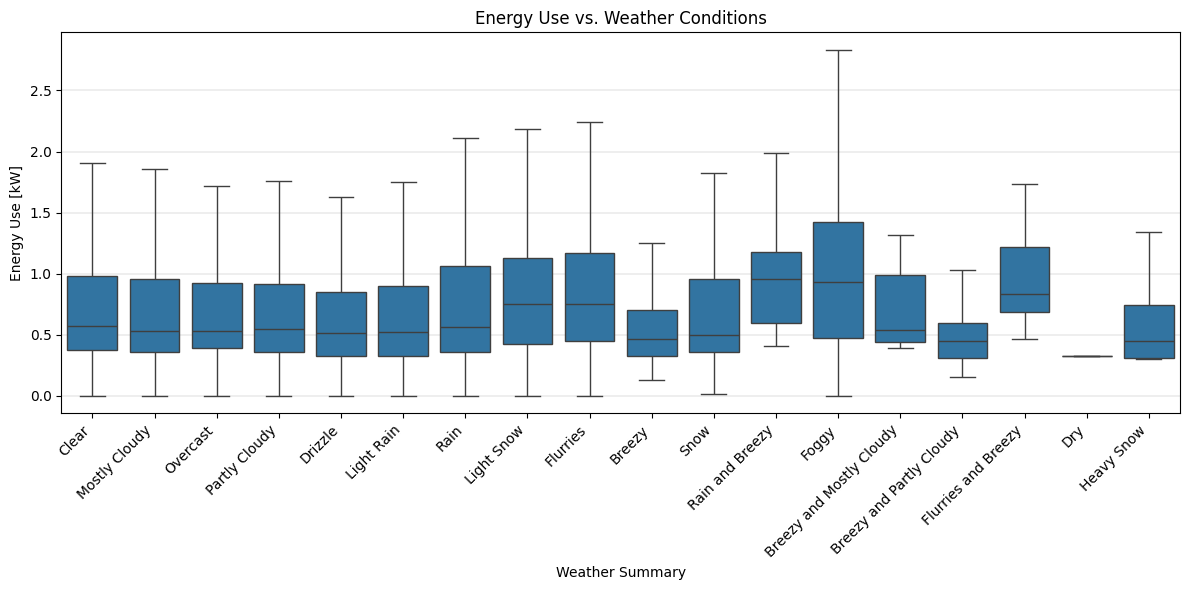

In [11]:
plot_energy_vs_weather(df)

Energy use tends to be slightly higher during conditions like *Rain*, *Light Snow*, *Foggy*, and *Rain and Breezy*, possibly due to indoor heating or activity patterns. Variability is substantial, especially under *Foggy* conditions, indicating inconsistent behavior. Clear and dry conditions show lower median consumption. These patterns hint at weather-driven usage shifts worth exploring in model features.

In [12]:
def plot_cloud_cover_distribution(df: pd.DataFrame) -> None:
    """
    Plot KDE distribution of cloud cover values after cleaning.
    """
    df_cleaned: pd.DataFrame = df.copy()
    df_cleaned['cloudCover'] = pd.to_numeric(df_cleaned['cloudCover'], errors='coerce')
    df_cleaned = df_cleaned.dropna(subset=['cloudCover'])

    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=df_cleaned,
        x='cloudCover',
        fill=True,
        bw_adjust=0.5,
        clip=(0, 1)
    )
    plt.title('Distribution of Cloud Cover')
    plt.xlabel('Cloud Cover (0 to 1)')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

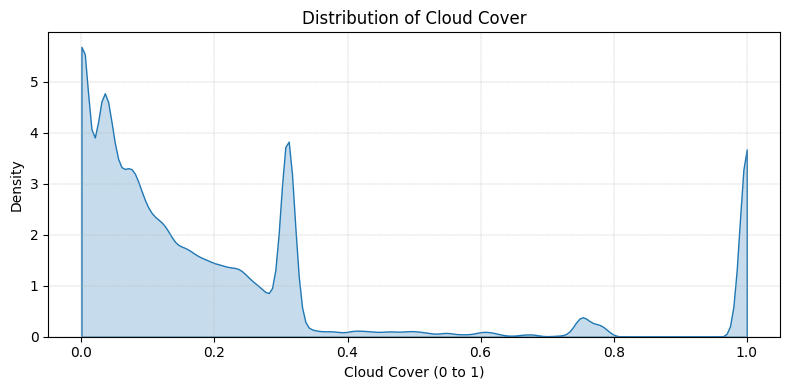

In [13]:
plot_cloud_cover_distribution(df)

`cloudCover` is multimodal with peaks at 0.0, ~0.3, and 1.0 → likely discretized, maybe treat as categorical or bin

In [14]:
def plot_energy_features_facet(df: pd.DataFrame, features: list[str]) -> None:
    """
    Plot each energy feature over time in its own subplot.
    """
    melted_df = df[['time'] + features].melt(id_vars='time', var_name='Feature', value_name='Consumption')

    g = sns.FacetGrid(melted_df, col='Feature', col_wrap=3, height=2.5, aspect=1.8, sharey=False)
    g.map(sns.lineplot, 'time', 'Consumption', linewidth=0.8)
    g.set_titles(col_template='{col_name}')
    g.set_axis_labels('Time', 'kW')

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.tight_layout()
    plt.show()

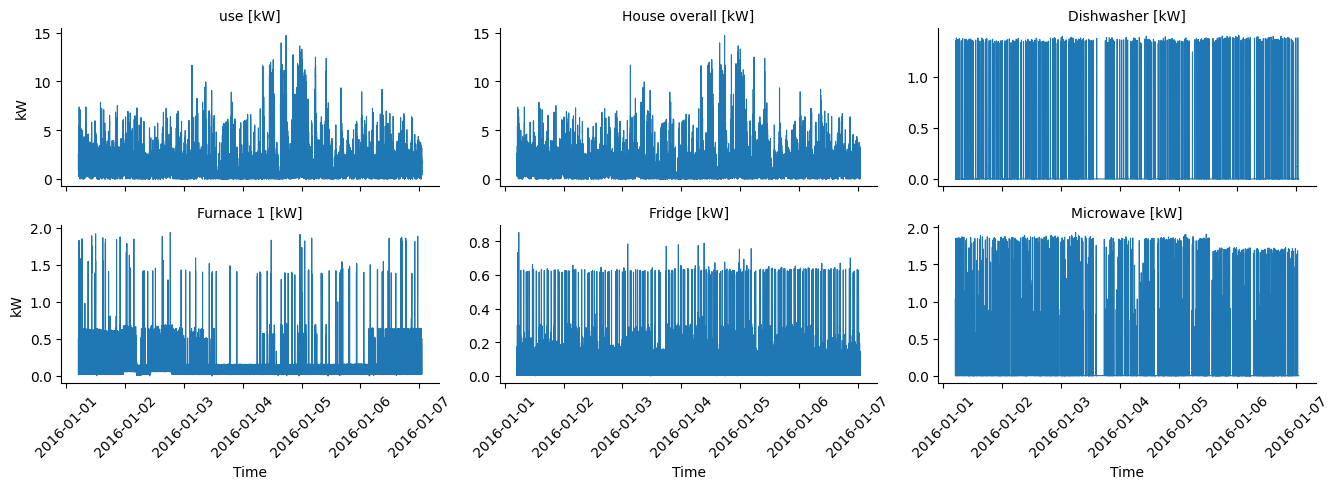

In [15]:
energy_features: list[str] = [
    'use [kW]',
    'House overall [kW]',
    'Dishwasher [kW]',
    'Furnace 1 [kW]',
    'Fridge [kW]',
    'Microwave [kW]'
]

plot_energy_features_facet(df, energy_features)

In [16]:
def plot_energy_features_facet_smoothed(df: pd.DataFrame, features: list[str], window: int = 300) -> None:
    """
    Plot each energy feature over time in its own subplot, smoothed with rolling mean.
    """
    smoothed_df = df[['time'] + features].copy()
    for feature in features:
        smoothed_df[feature] = smoothed_df[feature].rolling(window=window, min_periods=1).mean()

    melted_df = smoothed_df.melt(id_vars='time', var_name='Feature', value_name='Consumption')

    g = sns.FacetGrid(melted_df, col='Feature', col_wrap=3, height=2.5, aspect=1.8, sharey=False)
    g.map(sns.lineplot, 'time', 'Consumption', linewidth=0.8)
    g.set_titles(col_template='{col_name}')
    g.set_axis_labels('Time', 'kW')
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
    plt.tight_layout()
    plt.show()

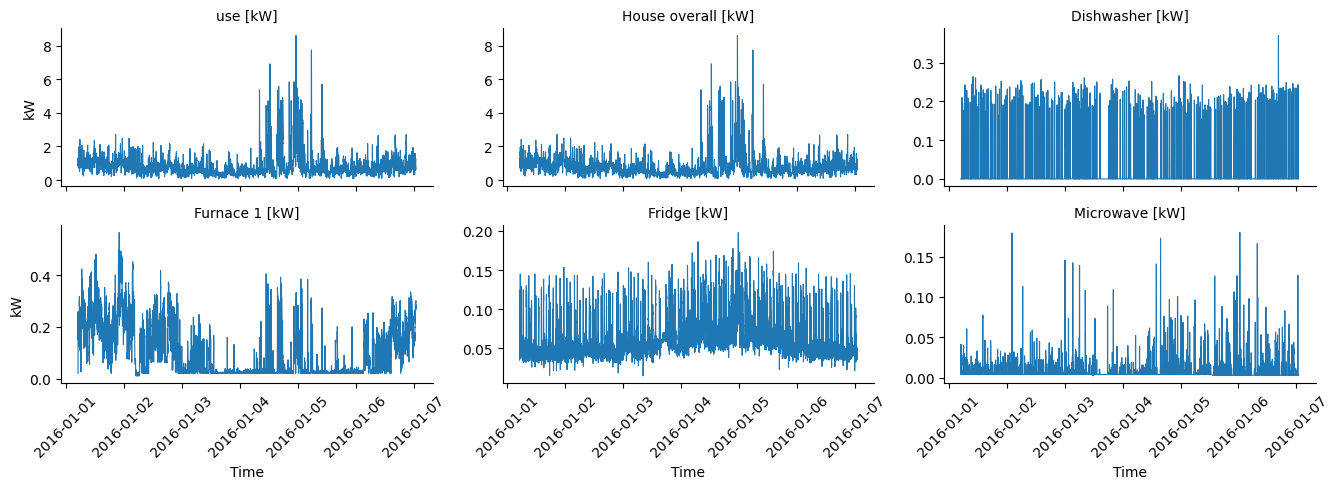

In [17]:
plot_energy_features_facet_smoothed(df, energy_features)

In [18]:
def detect_anomalies(df: pd.DataFrame, feature: str, method: str) -> Tuple[pd.DataFrame, np.ndarray]:
    df = df.copy()
    X = df[[feature]].values

    if method == "isolation_forest":
        model = IsolationForest(contamination=0.01, random_state=42)
        pred = model.fit_predict(X)

    elif method == "lof":
        model = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
        pred = model.fit_predict(X)

    elif method == "svm":
        model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
        pred = model.fit_predict(X)

    elif method == "knn":
        model = KNN(contamination=0.01)
        model.fit(X)
        pred = model.labels_

    elif method == "hbos":
        model = HBOS(contamination=0.01)
        model.fit(X)
        pred = model.labels_

    elif method == "mad":
        med = np.median(X)
        mad = median_abs_deviation(X)
        score = np.abs(X - med) / (mad + 1e-6)
        pred = (score > 3).astype(int)  # 1 = anomaly, 0 = normal

    else:
        raise ValueError(f"Unknown method: {method}")

    df["is_anomaly"] = (pred == -1) if method in ["isolation_forest", "lof", "svm"] else (pred == 1)
    return df, df["is_anomaly"].values

def plot_anomalies(df: pd.DataFrame, feature: str) -> None:
    plt.figure(figsize=(12, 4))
    plt.plot(df["time"], df[feature], label=feature, color="blue", linewidth=0.7)
    for idx in df[df["is_anomaly"]].index:
        plt.axvspan(df["time"].iloc[idx], df["time"].iloc[idx], color="yellow", alpha=0.5)
    plt.title(f"Anomaly Detection: {feature}")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

* use [kW]: Isolation Forest or LOF — spiky, irregular, global + local anomalies.
* House overall [kW]: Same as above — near identical to use [kW], good candidate.
* Dishwasher [kW]: HBOS or MAD — bimodal on/off device, histogram fits well.
* Furnace 1 [kW]: Matrix Profile or AutoEncoder — dense clusters + on/off phases.
* Furnace 2 [kW]: Matrix Profile or MAD — sparse cycles, clear structure.
* Home office [kW]: LOF or One-Class SVM — mid-density, many short bursts.
* Fridge [kW]: MAD or HBOS — repetitive, stable cycles, ideal for stat-based detection.
* Wine cellar [kW]: MAD — low variance, small drifts.
* Garage door [kW]: kNN Distance — few high spikes, rare events.
* Kitchen 12 [kW]: kNN Distance or MAD — mostly zero, small bursts.
* Kitchen 14 [kW]: LOF or HBOS — dense with fine-grained variability.
* Kitchen 38 [kW]: skip or MAD — basically flat noise, not anomaly-worthy.
* Barn [kW]: LOF or Isolation Forest — clear spikes + usage clusters.
* Well [kW]: HBOS or MAD — constant high usage, spike deviations only.
* Microwave [kW]: Matrix Profile or LOF — noisy on/off, frequent spikes.
* Living room [kW]: MAD or HBOS — low range, stat-based suitable.
* Solar [kW]: Matrix Profile — daily seasonality, pattern deviations.

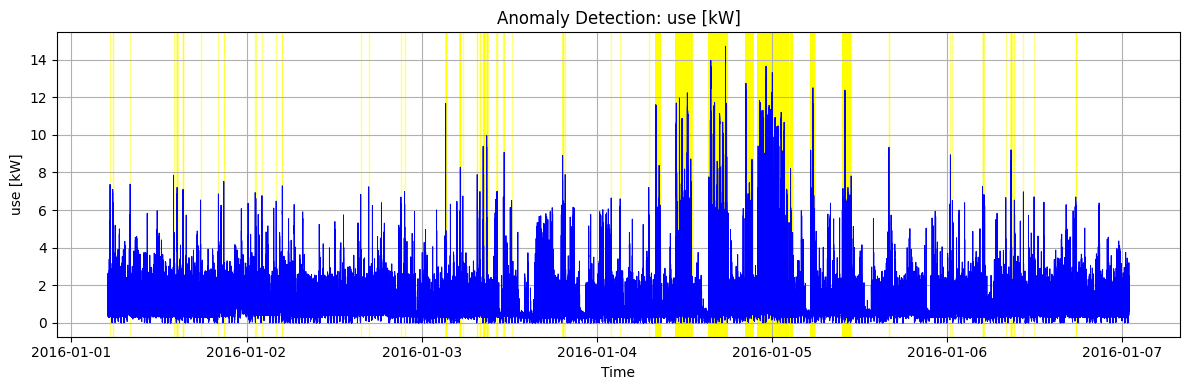

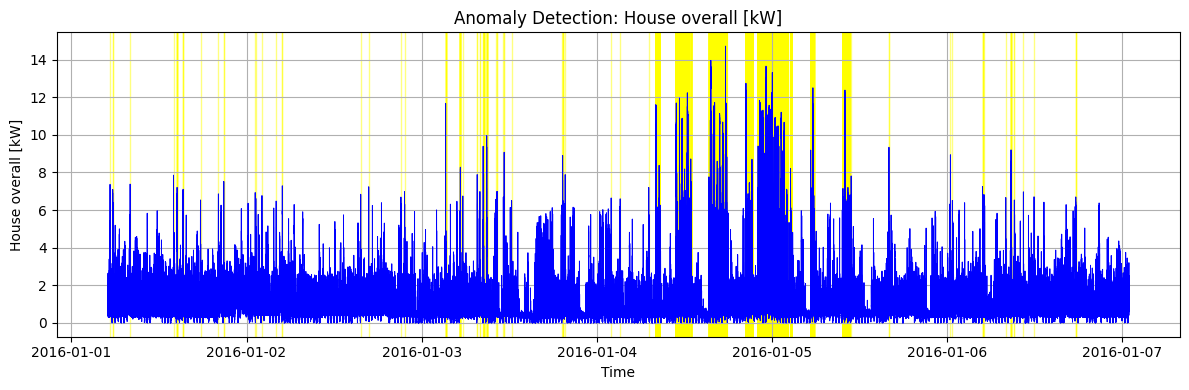

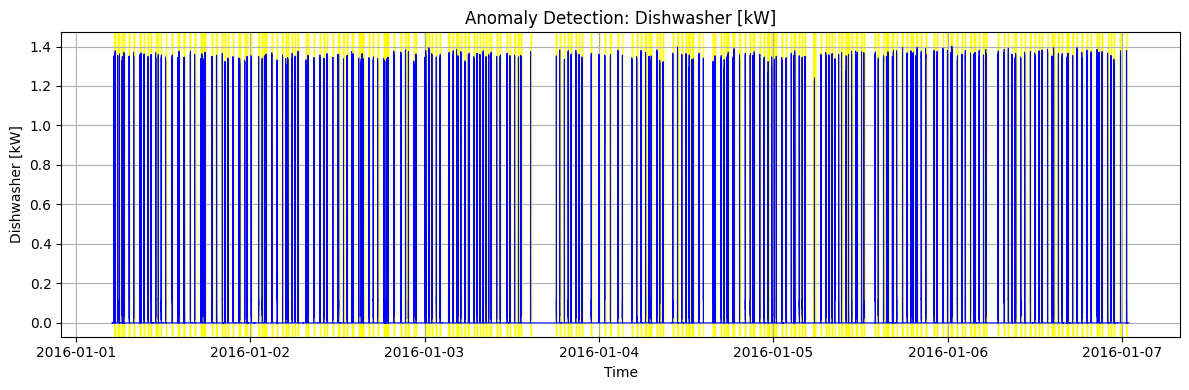

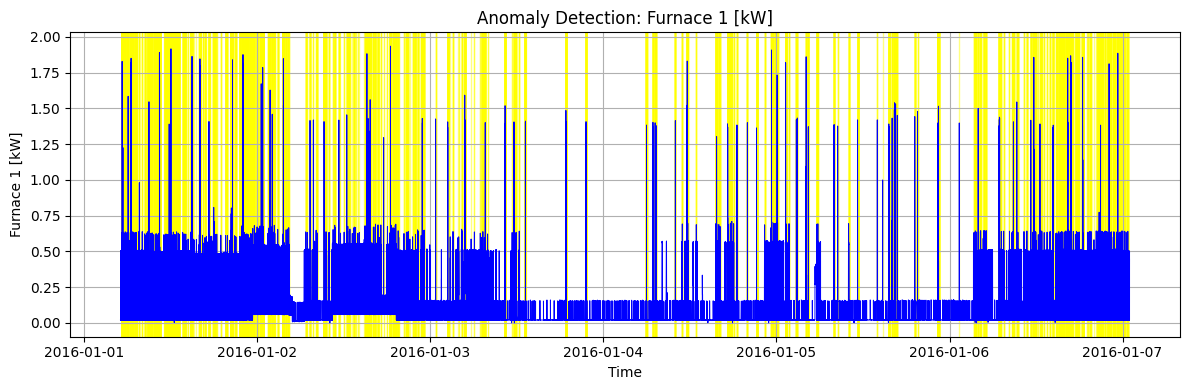

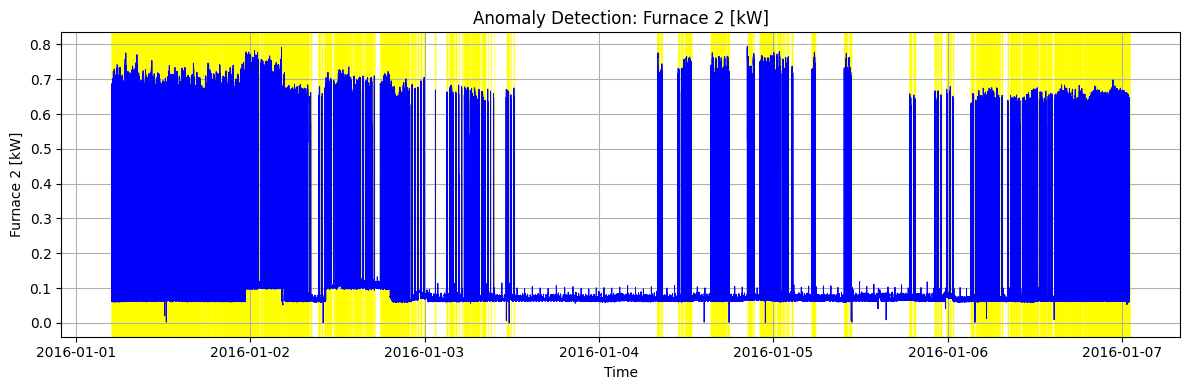

/Users/markuskuehnle/Documents/projects/smart-meter-energy-forecasting/.venv/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


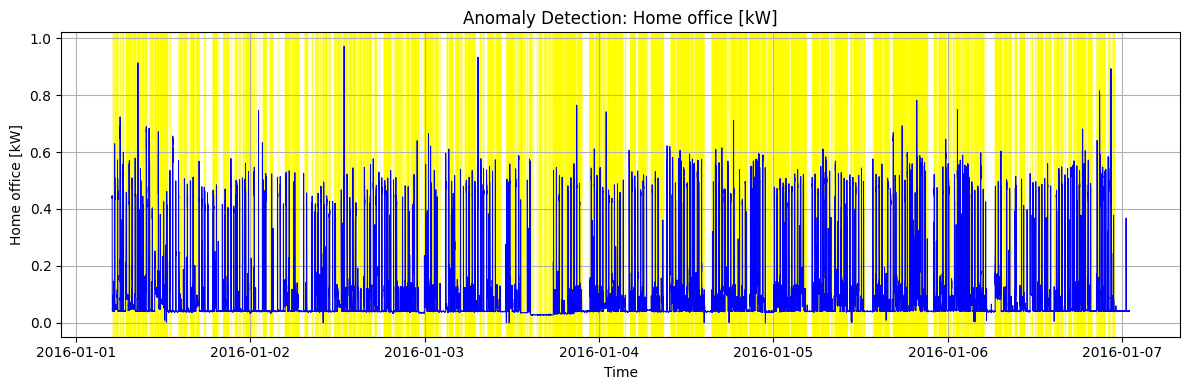

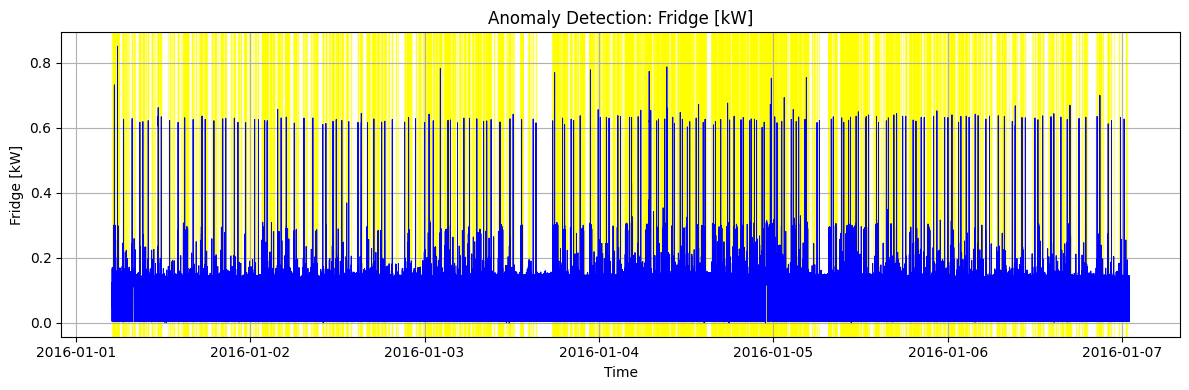

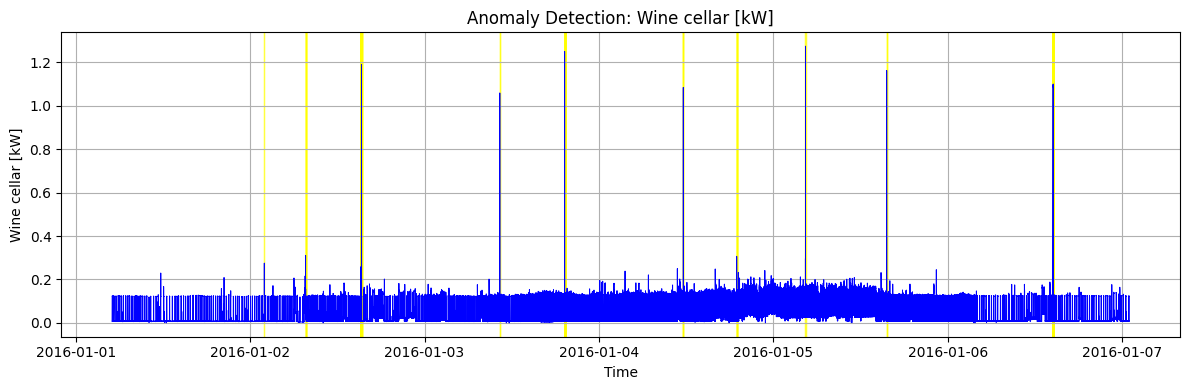

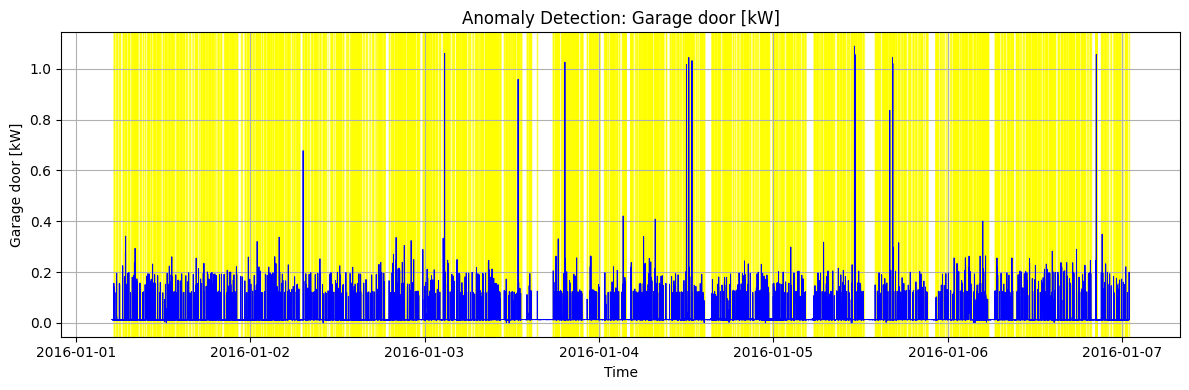

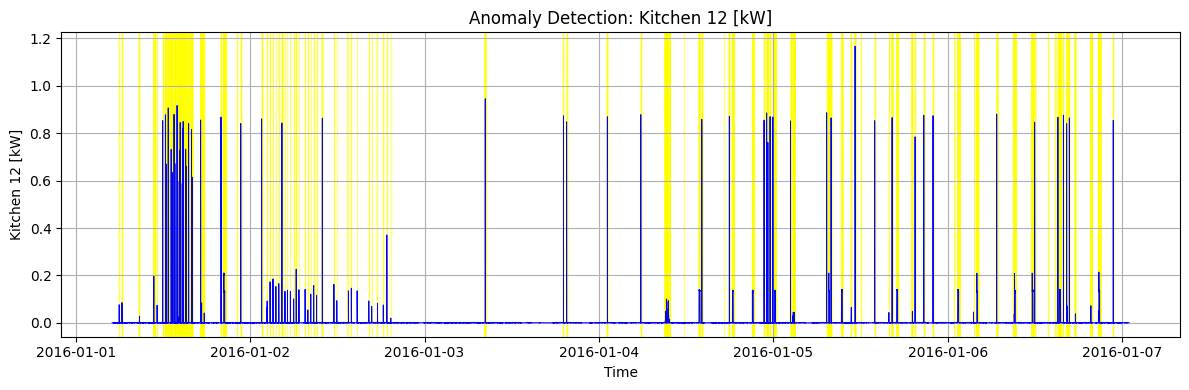

In [19]:
energy_feature_methods = {
    "use [kW]": "isolation_forest",
    "House overall [kW]": "isolation_forest",
    "Dishwasher [kW]": "hbos",
    "Furnace 1 [kW]": "hbos",
    "Furnace 2 [kW]": "hbos",
    "Home office [kW]": "lof",
    "Fridge [kW]": "hbos",
    "Wine cellar [kW]": "hbos",
    "Garage door [kW]": "knn",
    "Kitchen 12 [kW]": "knn",
}

for feature, method in energy_feature_methods.items():
    df_anomaly, _ = detect_anomalies(df, feature, method)
    plot_anomalies(df_anomaly, feature)

In [20]:
def plot_weather_feature_trends(df: pd.DataFrame, weather_features: list[str]) -> None:
    """
    Plot time series for selected weather features.
    """
    plt.figure(figsize=(14, 6))
    for feature in weather_features:
        plt.plot(df['time'], df[feature], label=feature, linewidth=0.8)

    plt.title('Weather Feature Trends Over Time')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.grid(True, linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

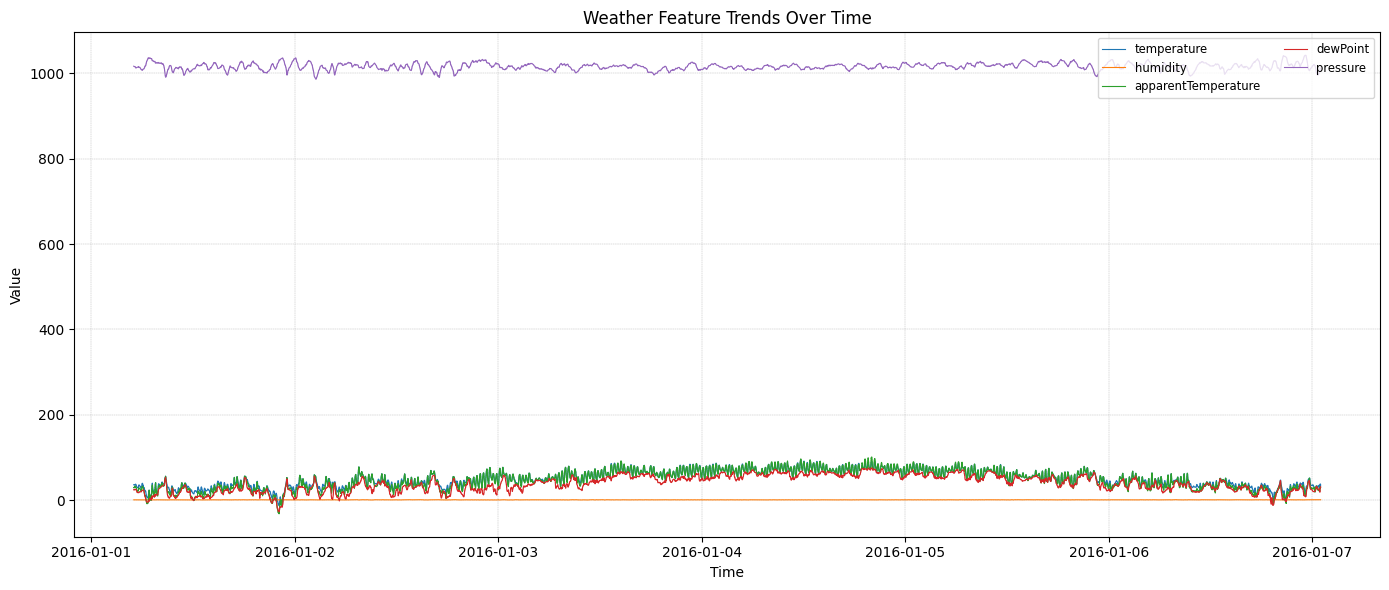

In [21]:
weather_features: list[str] = [
    'temperature',
    'humidity',
    'apparentTemperature',
    'dewPoint',
    'pressure'
]

plot_weather_feature_trends(df, weather_features)

In [22]:
def plot_energy_use_proportions(df: pd.DataFrame, application_columns: list[str]) -> None:
    """
    Plot proportion of energy usage for each application as a pie chart.
    """
    total_use_per_application: pd.Series = df[application_columns].sum()
    total_use: float = total_use_per_application.sum()
    proportion_per_application: pd.Series = total_use_per_application / total_use

    plt.figure(figsize=(8, 8))
    plt.pie(
        proportion_per_application,
        labels=proportion_per_application.index,
        autopct='%1.1f%%',
        startangle=140
    )
    plt.title('Proportion of Energy Use by Application')
    plt.tight_layout()
    plt.show()

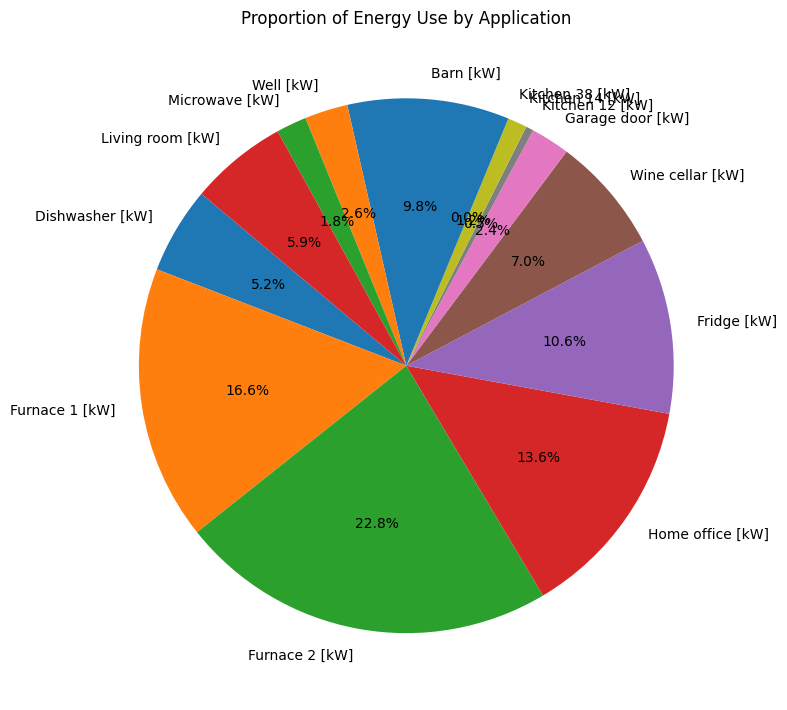

In [23]:
application_columns: list[str] = [
    'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]',
    'Fridge [kW]', 'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
    'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
    'Microwave [kW]', 'Living room [kW]'
]

plot_energy_use_proportions(df, application_columns)

NOTE: We should resample to 15-minute intervals because (1) second-level data is too granular and noisy for most analysis tasks, and (2) the dataset contains categorical features (e.g. weather descriptions) that do not make sense at second-level resolution. Resampling reduces noise and fits the problem definition better.